In [6]:
# Step 1: Load and Preprocess Dataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset from Google Drive or local path
# from google.colab import drive
# drive.mount('/content/drive')
# df = pd.read_csv('/content/drive/MyDrive/Churn_Banking_Modeling_ENG.csv')

df = pd.read_csv('Churn_Banking_Modeling_ENG.csv')
df = df.rename(columns={'flag_request_closure': 'Target'})
df['Target'] = df['Target'].map({'si': 1, 'no': 0})
df = df.drop(columns=['customer_id', 'str_prov_domicile', 'str_prov_residence', 'str_profession'], errors='ignore')

# Drop high-missing columns
missing_ratio = df.isnull().mean()
df = df.drop(columns=missing_ratio[missing_ratio > 0.6].index)

# Encode categorical variables
cat_cols = df.select_dtypes(include='object').columns.tolist()
for col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# Fill missing values
df = df.fillna(df.median(numeric_only=True))


In [7]:
# Step 2: Train-Test Split and Downsampling
X = df.drop(columns='Target')
y = df['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

train_df = pd.concat([X_train, y_train], axis=1)
minority = train_df[train_df['Target'] == 1]
majority = train_df[train_df['Target'] == 0].sample(n=len(minority) * 5, random_state=42)
train_bal = pd.concat([majority, minority])

X_train_bal = train_bal.drop(columns='Target')
y_train_bal = train_bal['Target']


In [8]:
# Step 3: Model Training and Evaluation
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

models = {
    'Decision Tree': DecisionTreeClassifier(min_samples_leaf=50, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
}

for name, model in models.items():
    print(f"\n=== {name} ===")
    model.fit(X_train_bal, y_train_bal)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    print(classification_report(y_test, y_pred, zero_division=0))
    print("AUC Score:", roc_auc_score(y_test, y_prob))



=== Decision Tree ===
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     75077
           1       0.04      0.32      0.08       397

    accuracy                           0.96     75474
   macro avg       0.52      0.64      0.53     75474
weighted avg       0.99      0.96      0.97     75474

AUC Score: 0.8356555447741998

=== Random Forest ===
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     75077
           1       0.07      0.40      0.12       397

    accuracy                           0.97     75474
   macro avg       0.53      0.69      0.55     75474
weighted avg       0.99      0.97      0.98     75474

AUC Score: 0.8805942272063318

=== Logistic Regression ===
              precision    recall  f1-score   support

           0       1.00      0.72      0.84     75077
           1       0.01      0.73      0.03       397

    accuracy                           0.72    

C:\Users\rtira\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


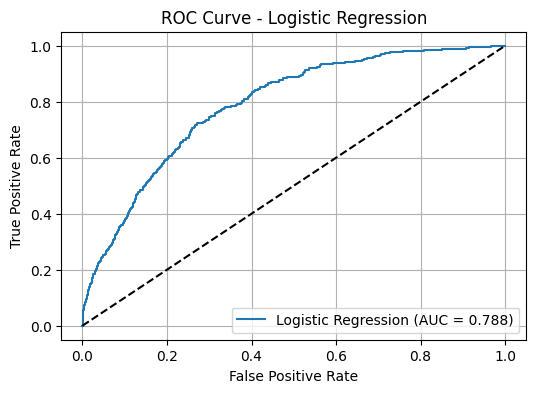

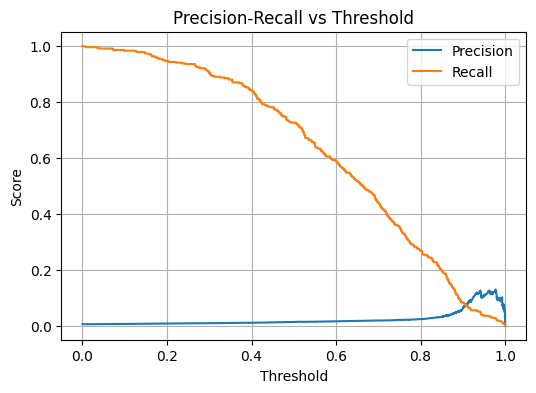

In [9]:
# Step 4: ROC Curve and PR Threshold (Logistic Regression)
lr = models['Logistic Regression']
y_prob_lr = lr.predict_proba(X_test)[:, 1]

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_lr)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc_score(y_test, y_prob_lr):.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.grid()
plt.legend()
plt.show()

# PR vs Threshold
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_lr)
plt.figure(figsize=(6, 4))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall vs Threshold')
plt.legend()
plt.grid()
plt.show()


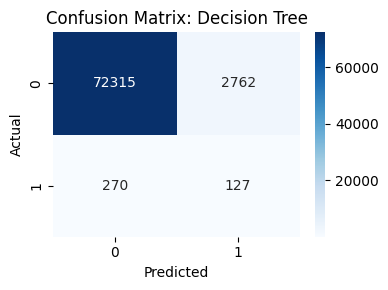

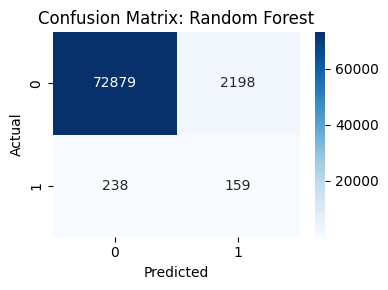

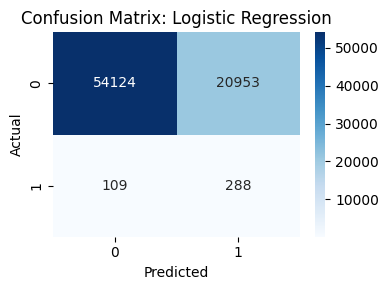

In [10]:
# Step 5: Confusion Matrix Heatmaps
for name, model in models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()
